In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install category_encoders
!wget https://raw.githubusercontent.com/gustavovargas/tfm_afi/master/utils.py
!pip install lime

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.externals import joblib
from utils import LoansTransformer
import category_encoders as ce

from lime.lime_tabular import LimeTabularExplainer
from utils import LimeFormat
from functools import partial

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
from keras.models import Sequential
from keras.layers.core import Dense 
from keras.layers.core import Activation

from keras.layers import Input, Add, LeakyReLU, BatchNormalization, Concatenate
from keras.models import Model, load_model

In [0]:
x_train = joblib.load('/content/drive/My Drive/TFM/data/x_train.pkl').reset_index(drop=True)
x_test = joblib.load('/content/drive/My Drive/TFM/data/x_test.pkl').reset_index(drop=True)
y_train = joblib.load('/content/drive/My Drive/TFM/data/y_train.pkl').reset_index(drop=True)
y_test = joblib.load('/content/drive/My Drive/TFM/data/y_test.pkl').reset_index(drop=True)

In [0]:
x_train.head()

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq
0,16200.0,1,18.49,21,3,RENT,45000.0,Source Verified,102,debt_consolidation,GA,23.44,0.0,752,0.0,25.0,0.0,19531.0,57.6,48.0,1,16033.91,465.63,166.09,299.54,0.0,0.0,0.0,97,482.27,104,0.0,0.0
1,10000.0,0,19.52,18,10,RENT,40000.0,Not Verified,73,credit_card,FL,12.09,0.0,719,1.0,11.0,0.0,7169.0,62.9,14.0,1,0.00,8861.98,5625.67,3236.31,0.0,0.0,0.0,95,370.00,104,0.0,0.0
2,8300.0,0,16.99,17,10,RENT,32500.0,Not Verified,96,debt_consolidation,NJ,26.99,0.0,697,1.0,11.0,0.0,14660.0,57.0,19.0,1,6997.14,2063.33,1302.86,760.47,0.0,0.0,0.0,97,295.88,104,0.0,0.0
3,12000.0,1,9.99,7,7,OWN,70000.0,Source Verified,95,debt_consolidation,CA,27.14,0.0,370,0.0,11.0,1.0,6026.0,42.7,30.0,0,10723.18,2032.62,1276.82,755.80,0.0,0.0,0.0,97,254.91,104,0.0,0.0
4,4000.0,0,9.99,7,10,MORTGAGE,64000.0,Verified,100,major_purchase,NY,27.79,2.0,489,0.0,19.0,0.0,50000.0,27.2,36.0,0,3710.35,382.71,289.65,93.06,0.0,0.0,0.0,97,129.05,104,0.0,0.0


In [0]:
lt = joblib.load('/content/drive/My Drive/TFM/data/lt_transformer.pkl')

In [0]:
lt.categorical_features

['home_ownership', 'verification_status', 'purpose', 'addr_state']

In [0]:
preprocessor = ce.OneHotEncoder(cols = lt.categorical_features, return_df=True, handle_unknown="ignore")

In [0]:
column_names = preprocessor.fit_transform(x_train).columns.values

In [0]:
train = preprocessor.fit_transform(x_train)
train.shape

(577834, 103)

In [0]:
train.head()

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership_1,home_ownership_2,home_ownership_3,home_ownership_4,home_ownership_5,home_ownership_6,annual_inc,verification_status_1,verification_status_2,verification_status_3,issue_d,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,purpose_11,purpose_12,purpose_13,purpose_14,addr_state_1,addr_state_2,addr_state_3,addr_state_4,addr_state_5,addr_state_6,addr_state_7,addr_state_8,addr_state_9,addr_state_10,...,addr_state_34,addr_state_35,addr_state_36,addr_state_37,addr_state_38,addr_state_39,addr_state_40,addr_state_41,addr_state_42,addr_state_43,addr_state_44,addr_state_45,addr_state_46,addr_state_47,addr_state_48,addr_state_49,addr_state_50,addr_state_51,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq
0,16200.0,1,18.49,21,3,1,0,0,0,0,0,45000.0,1,0,0,102,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.44,0.0,752,0.0,25.0,0.0,19531.0,57.6,48.0,1,16033.91,465.63,166.09,299.54,0.0,0.0,0.0,97,482.27,104,0.0,0.0
1,10000.0,0,19.52,18,10,1,0,0,0,0,0,40000.0,0,1,0,73,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.09,0.0,719,1.0,11.0,0.0,7169.0,62.9,14.0,1,0.00,8861.98,5625.67,3236.31,0.0,0.0,0.0,95,370.00,104,0.0,0.0
2,8300.0,0,16.99,17,10,1,0,0,0,0,0,32500.0,0,1,0,96,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26.99,0.0,697,1.0,11.0,0.0,14660.0,57.0,19.0,1,6997.14,2063.33,1302.86,760.47,0.0,0.0,0.0,97,295.88,104,0.0,0.0
3,12000.0,1,9.99,7,7,0,1,0,0,0,0,70000.0,1,0,0,95,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27.14,0.0,370,0.0,11.0,1.0,6026.0,42.7,30.0,0,10723.18,2032.62,1276.82,755.80,0.0,0.0,0.0,97,254.91,104,0.0,0.0
4,4000.0,0,9.99,7,10,0,0,1,0,0,0,64000.0,0,0,1,100,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27.79,2.0,489,0.0,19.0,0.0,50000.0,27.2,36.0,0,3710.35,382.71,289.65,93.06,0.0,0.0,0.0,97,129.05,104,0.0,0.0


In [0]:
test = preprocessor.transform(x_test)
test.shape

(247647, 103)

In [0]:
input_tensor = Input(shape=(train.shape[1],))
model0 = BatchNormalization()(input_tensor)

model1 = Dense(10)(model0)
model11 = BatchNormalization()(model1)

model2 = Concatenate()([model0,model11])

model3 = Dense(1, activation = 'linear')(model2)

model5 = Dense(256)(model3)
model5 = BatchNormalization()(model5)
model5 = LeakyReLU(0.01)(model5)

model5 = Dense(128)(model5)
model5 = LeakyReLU(0.01)(model5)

model5 = Dense(64)(model5)
model5 = LeakyReLU(0.01)(model5)

model5 = Dense(32)(model5)
model5 = LeakyReLU(0.01)(model5)

model5 = Dense(16)(model5)
model5 = LeakyReLU(0.01)(model5)

model5 = Dense(4)(model5)
model5 = LeakyReLU(0.01)(model5)

model6 = Dense(1, activation = 'sigmoid')(model5)

model = Model(inputs=input_tensor,outputs=model6)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train,
                    y_train,
                    validation_split=0.20,
                    batch_size=1024,
                    epochs = 50,
                    verbose = 2)

score = model.evaluate(test, y_test)
print("Test loss", score[0])
print("Test accuracy", score[1])

Train on 462267 samples, validate on 115567 samples
Epoch 1/50


In [0]:
model.save('/content/drive/My Drive/TFM/data/model_1neuron.h5')

In [0]:
model = load_model('/content/drive/My Drive/TFM/data/model_1neuron.h5')

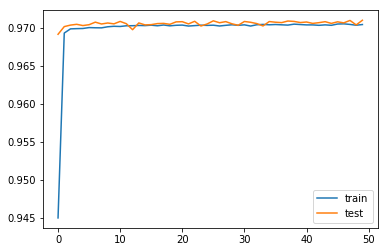

In [0]:
# plot history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

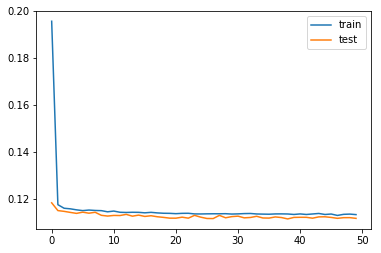

In [0]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

([<matplotlib.axis.XTick at 0x7f0a63150668>,
 <a list of 113 Text xticklabel objects>)

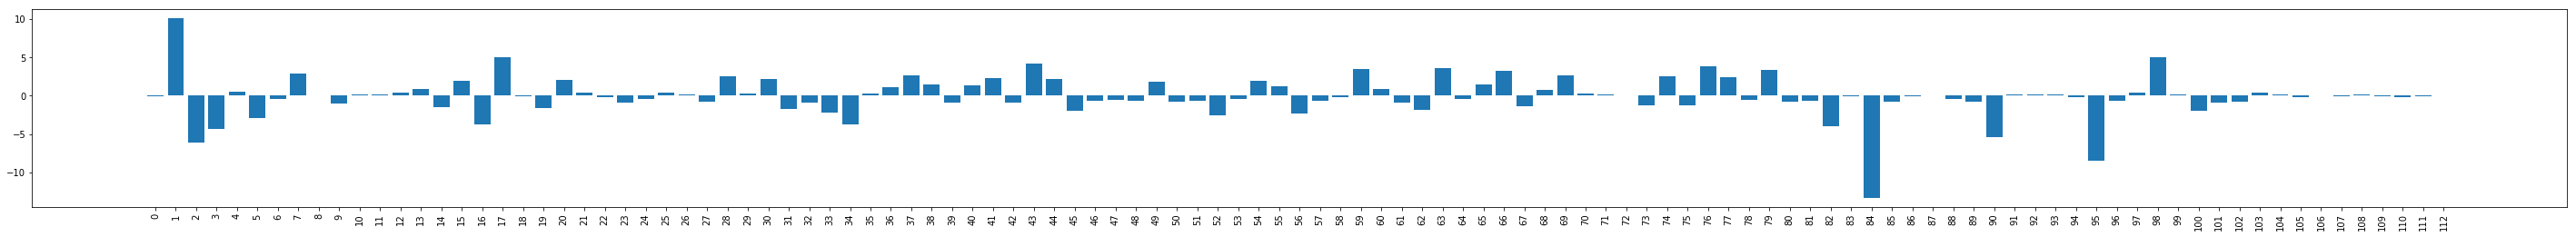

In [0]:
plt.figure(figsize=(50,4))
plt.bar([str(i) for i in range(len(model.layers[4].get_weights()[0]))], y)
plt.xticks([str(i) for i in range(len(model.layers[4].get_weights()[0]))], rotation='vertical')